
[1/7] Loading dataset from Consumer Finance URL...
Initial dataset shape: (11535877, 18)

[2/7] Filtering and cleaning data...
Filtered dataset shape: (1323496, 2)

Class distribution:
Product
Credit reporting, credit repair services, or other personal consumer reports    807276
Debt collection                                                                 371899
Mortgage                                                                        134860
Consumer Loan                                                                     9461
Name: count, dtype: int64

[3/7] Preprocessing text data...
Dataset shape after preprocessing: (1323494, 3)

[4/7] Splitting data into train and test sets...
Training set size: 1058795
Test set size: 264699

[5/7] Training classification models...

  Training MultinomialNB...
    Accuracy: 0.8623
    Precision (macro): 0.7077
    Recall (macro): 0.7211
    F1-Score (macro): 0.7081

  Training LogisticRegression...
    Accuracy: 0.9088
    Precision (macr

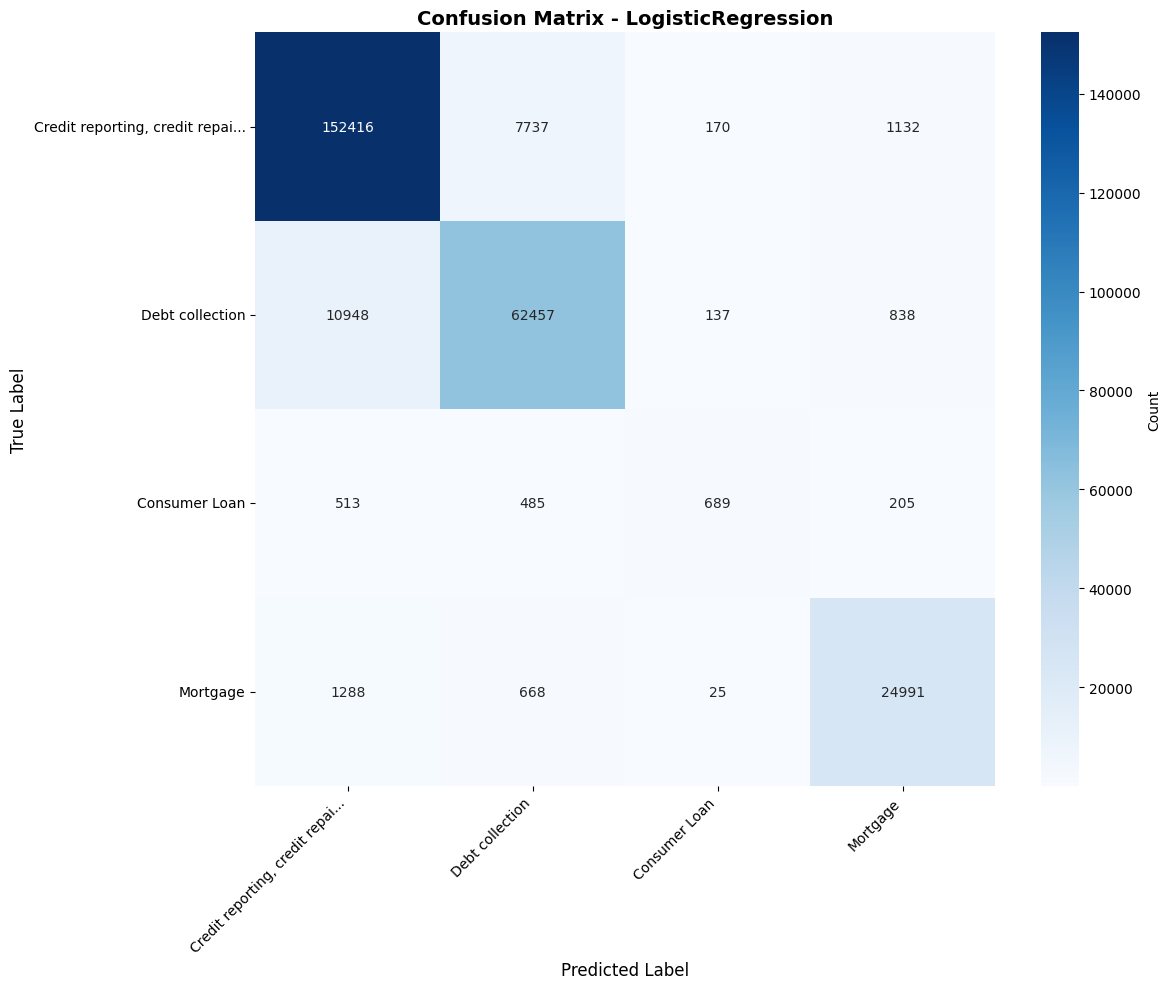

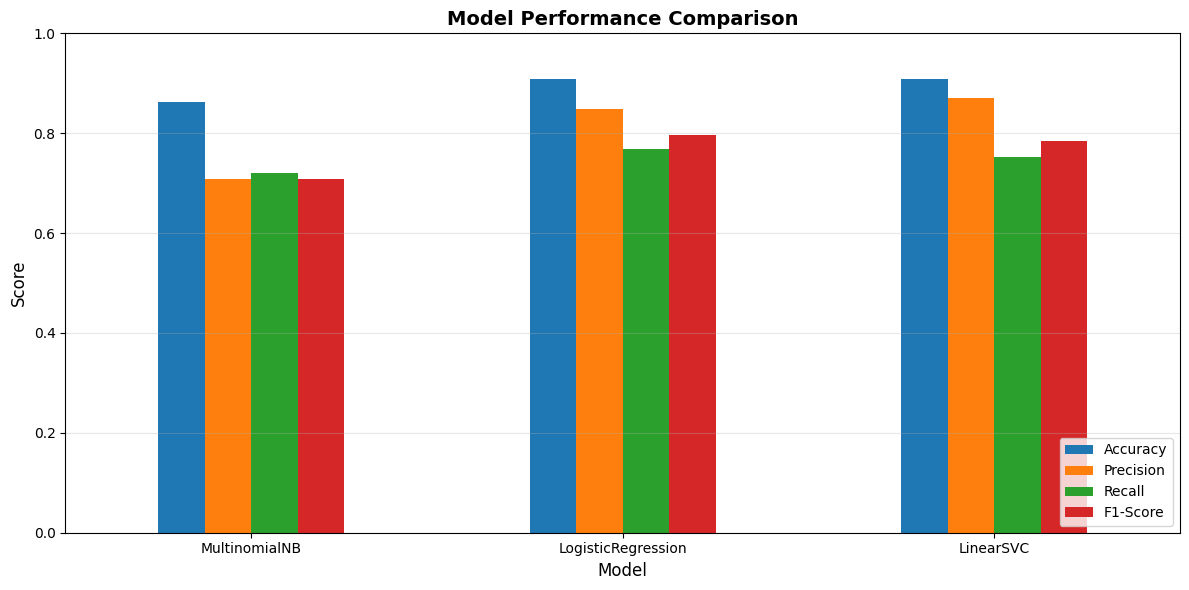

In [ ]:
import pandas as pd
import numpy as np
import re
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

print("Downloading NLTK stopwords...")
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

print("\n[1/7] Loading dataset from Consumer Finance URL...")
df = pd.read_csv('https://files.consumerfinance.gov/ccdb/complaints.csv.zip')
print(f"Initial dataset shape: {df.shape}")

print("\n[2/7] Filtering and cleaning data...")
df = df[['Product', 'Consumer complaint narrative']].copy()

df = df.dropna(subset=['Consumer complaint narrative'])

target_categories = [
    'Credit reporting, credit repair services, or other personal consumer reports',
    'Debt collection',
    'Consumer Loan',
    'Mortgage'
]

df = df[df['Product'].isin(target_categories)]
print(f"Filtered dataset shape: {df.shape}")
print(f"\nClass distribution:\n{df['Product'].value_counts()}")

def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    text = text.lower()

    text = re.sub(r'[^a-z\s]', '', text)

    text = ' '.join(text.split())

    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 2]
    
    return ' '.join(words)

print("\n[3/7] Preprocessing text data...")
df['cleaned_text'] = df['Consumer complaint narrative'].apply(preprocess_text)

df = df[df['cleaned_text'].str.len() > 0]
print(f"Dataset shape after preprocessing: {df.shape}")

X = df['cleaned_text']
y = df['Product']

print("\n[4/7] Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

print("\n[5/7] Training classification models...")

models = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    'LinearSVC': LinearSVC(max_iter=2000, random_state=42)
}

results = {}
trained_pipelines = {}

for model_name, model in models.items():
    print(f"\n  Training {model_name}...")

    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='macro', zero_division=0
    )
    
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'predictions': y_pred
    }
    
    trained_pipelines[model_name] = pipeline
    
    print(f"    Accuracy: {accuracy:.4f}")
    print(f"    Precision (macro): {precision:.4f}")
    print(f"    Recall (macro): {recall:.4f}")
    print(f"    F1-Score (macro): {f1:.4f}")

print("\n[6/7] Model Performance Comparison:")
print("="*80)
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']]
print(comparison_df.to_string())
print("="*80)

best_model_name = comparison_df['F1-Score'].idxmax()
best_pipeline = trained_pipelines[best_model_name]
best_predictions = results[best_model_name]['predictions']

print(f"\nBest performing model: {best_model_name}")

print("\n[7/7] Saving models...")
for model_name, pipeline in trained_pipelines.items():
    filename = f'model_{model_name}.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(pipeline, f)
    print(f"  Saved: {filename}")

with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_pipeline, f)
print(f"  Saved: best_model.pkl ({best_model_name})")

print(f"\n{'='*80}")
print(f"Detailed Classification Report for {best_model_name}:")
print(f"{'='*80}")
print(classification_report(y_test, best_predictions, target_names=target_categories))

print("\nGenerating confusion matrix visualization...")
cm = confusion_matrix(y_test, best_predictions, labels=target_categories)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=[cat[:30] + '...' if len(cat) > 30 else cat for cat in target_categories],
    yticklabels=[cat[:30] + '...' if len(cat) > 30 else cat for cat in target_categories],
    cbar_kws={'label': 'Count'}
)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
print("Saved: confusion_matrix.png")

print("\nGenerating performance comparison chart...")
fig, ax = plt.subplots(figsize=(12, 6))
comparison_df_plot = comparison_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']]
comparison_df_plot.plot(kind='bar', ax=ax, rot=0)
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("Saved: model_comparison.png")

print("\n" + "="*80)
print("Classification pipeline completed successfully!")
print("="*80)
print("\nSaved files:")
print("  - model_MultinomialNB.pkl")
print("  - model_LogisticRegression.pkl")
print("  - model_LinearSVC.pkl")
print("  - best_model.pkl")
print("  - confusion_matrix.png")
print("  - model_comparison.png")
print("\nTo load a saved model:")
print("  with open('best_model.pkl', 'rb') as f:")
print("      model = pickle.load(f)")
print("  predictions = model.predict(['your complaint text here'])")